# ADA final exam (Fall 2021)

This exam consists of 2 parts.
The first part has 3 tasks.
The second part has 2 tasks.
The two parts are completely independent of each other.

## Important: The data used for this exam **is not entirely real.** A great deal of it has been artificially created or modified. Conclusions drawn from this data have no real link to reality!

In [1]:
%matplotlib inline

# General
import pandas as pd
import numpy as np

# For plotting
import matplotlib.pyplot as plt
import seaborn as sns

# For graph-related stuff
import networkx as nx

# For regression analyses and statistical tests
import scipy.stats as stats
import statsmodels.stats
import statsmodels.formula.api as smf

# For classification
from sklearn import linear_model as lm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


## Part 1 — Faculty hiring network

For the first part of the exam, you will analyze data from a faculty hiring network. After completing their Ph.D., researchers who want to pursue an academic career must compete for relatively few permanent positions (as “faculty”, i.e., professors) in a highly competitive job market. You will analyze a directed graph that captures the dynamics of this hiring process in the United States:


- Each node $u$ in this graph represents a different American university.
- For each university, we also provide a score that captures how highly  this university is ranked (e.g., Stanford University is ranked more highly than the University of Alabama). The higher the score, the more highly ranked the university.
- Each directed edge $(u,v)$ in this graph represents a hiring decision where someone who did their Ph.D. at university $u$ subsequently was hired by university $v$. Each edge is also associated with a gender label, which specifies if the person hired was a man (M) or a woman (F).
- Note that, when multiple researchers were trained at a given university $u$ and subsequently hired by university $v$, there will be multiple edges pointing from $u$ to $v$, each of which corresponds to a different person.


## Files (in the `./data/part-1/` folder)

- `nodelist.tsv` a tab-separated file containing the nodes of the graph. Recall that each node represents a different university. The file has these columns:
    - `u` — the node index;
    - `score` — the rank of the university (the higher the better);
    - `name` — the name of the university.

- `edgelist.tsv` a tab-separated file containing the edges of the graph. Recall that each edge represents a hiring decision. The file has columns:
    - `u` — the source university, where the person got their Ph.D.;
    - `v` — the target university, where the person was hired;
    - `gender` — the gender of the person.


### Task 1 — (20 points)

1. Using the above files, create the directed graph representing the hiring network using `networkx`.
Each node should contain the attributes `score` and `name`, and each edge should contain the attribute `gender`.
Print the total numbers of nodes and edges in the graph.

2. Create a plot that allows you to easily visualize **(a)** what fraction of all researchers in the graph are hired by the $N$ universities that hire the most; and  **(b)** what fraction of all researchers in the graph are trained by the $N$ universities whose students get hired the most.
Here, $N$ could be any number between 1 and the number of universities.

3. **/Multiple choice:/** Which centrality metric(s) is/are illustrated in the plot you made for the previous subtask? Select all that apply from the list below and **justify your answer.**
    1. Betweenness centrality
    2. In-degree centrality
    3. Out-degree centrality
    4. PageRank centrality

4. **/True or false:/** Search engines such as Google have historically used PageRank centrality as a signal to determine the importance of pages on the Web. Is the following statement **true** or **false**? Justify. **"In the faculty hiring network, PageRank centrality is positively correlated with university score, that is, universities with higher scores are more likely to also have higher PageRank centrality."**


In [87]:
# First, we lode both lists:
data_folder = './data/part-1/'
nodes = pd.read_csv(data_folder + 'nodelist.tsv', sep = '\t')
edges = pd.read_csv(data_folder + 'edgelist.tsv', sep='\t')
nodes.head(10)

,u,score,name
0,1,100.000000,Stanford University
1,2,99.956665,UC Berkeley
2,3,99.301230,MIT
3,4,98.369536,California Institute of Technology
4,5,97.892855,Harvard University
5,6,96.717404,Cornell University
6,7,96.181139,Carnegie Mellon University
7,8,96.159471,Princeton University
8,9,95.801961,Yale University
9,10,95.216944,University of Washington


In [88]:
# Check if universities names are all defined:
print(nodes['name'].isna().sum())
# Check if they are all unique:
print(len(nodes['name'].unique()) == len(nodes))
print(len(nodes['u'].unique()) == len(nodes))

0
True
True


In [89]:
# since the indices are unique, index based on u:
nodes.set_index('u', inplace=True)

In [90]:
nodes.head(10)

,score,name
u,,
1,100.000000,Stanford University
2,99.956665,UC Berkeley
3,99.301230,MIT
4,98.369536,California Institute of Technology
5,97.892855,Harvard University
6,96.717404,Cornell University
7,96.181139,Carnegie Mellon University
8,96.159471,Princeton University
9,95.801961,Yale University


In [91]:
edges.head(10)

,u,v,gender
0,1,1,F
1,1,1,F
2,1,1,F
3,1,1,M
4,1,1,M
5,1,1,F
6,1,1,F
7,1,1,F
8,1,1,M
9,1,2,F


In [92]:
print('There are ', len(nodes), 'universities')

There are  205 universities


In [93]:
# Helper function for printing various graph properties from course:
def describe_graph(G):
    print(nx.info(G)) 
    if nx.is_connected(G):
        print("Avg. Shortest Path Length: %.4f" %nx.average_shortest_path_length(G))
        print("Diameter: %.4f" %nx.diameter(G)) # Longest shortest path
    else:
        print("Graph is not connected")
        print("Diameter and Avg shortest path length are not defined!")
    print("Sparsity: %.4f" %nx.density(G))  # #edges/#edges-complete-graph
    # #closed-triplets(3*#triangles)/#all-triplets
    print("Global clustering coefficient aka Transitivity: %.4f" %nx.transitivity(G))

In [121]:
#1. From edgelist and nodelist, create the graphs:
UniG =nx.from_pandas_edgelist(edges, 'u', 'v', edge_attr='gender', create_using= nx.DiGraph())
# Print some info about the graph:
print('There are ', len(UniG), 'nodes')
print('There are ', len(UniG.edges()), 'edges')


There are  205 nodes
There are  2881 edges


In [122]:
# add node attributes by passing dictionary of type name -> attribute
nx.set_node_attributes(UniG, nodes['score'].to_dict(), 'score' )
nx.set_node_attributes(UniG, nodes['name'].to_dict(), 'name' )

In [123]:
# Access to node attributes:
UniG.nodes[1]

{'score': 100.0, 'name': 'Stanford University'}

In [124]:
# Helper function for visualizing the graph from course:
def visualize_graph(G, with_labels=True, k=None, alpha=1.0, node_shape='o'):
    #nx.draw_spring(G, with_labels=with_labels, alpha = alpha)
    pos = nx.spring_layout(G, k=k)
    if with_labels:
        lab = nx.draw_networkx_labels(G, pos, labels=dict([(n, n) for n in G.nodes()]))
    ec = nx.draw_networkx_edges(G, pos, alpha=alpha)
    nc = nx.draw_networkx_nodes(G, pos, nodelist=G.nodes(), node_color='g', node_shape=node_shape)
    plt.axis('off')

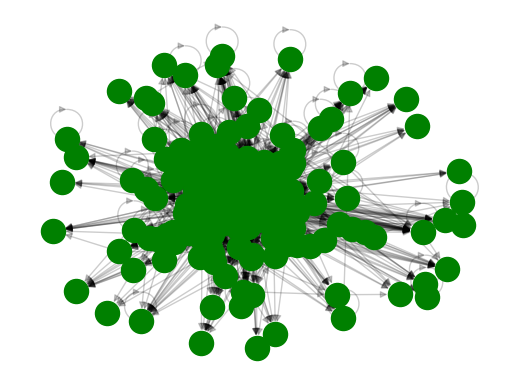

In [127]:
visualize_graph(UniG, False, k=0.22, alpha=0.2, node_shape='o')

2. Create a plot that allows you to easily visualize **(a)** what fraction of all researchers in the graph are hired by the $N$ universities that hire the most; and  **(b)** what fraction of all researchers in the graph are trained by the $N$ universities whose students get hired the most.
Here, $N$ could be any number between 1 and the number of universities.

In [135]:
# (a) fraction of all researchers (i.e. total number of edges) that are hired by N universities hiring the most (i.e. highest degree = highest number of adjacent in_edges):
# sort universities by their in_degree (i.e. number of incoming edges):
from operator import itemgetter
degrees = dict(UniG.in_degree(UniG.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
universities_hiring = []
fractions_hiring = []
N = 20 # top 20 universities
# And the top N most hiring universities are:
for university, degree in sorted_degree[:N]:
    fraction_hiring = (degree/len(UniG.edges))
    fractions_hiring.append(fraction_hiring)
    print(UniG.nodes[university]['name'], 'hires', degree, 'researchers over', len(UniG.edges), 'i.e. {:.1%} of all researchers.'.format(fraction_hiring))
    universities_hiring.append(UniG.nodes[university]['name'])

Georgia Tech hires 33 researchers over 2881 i.e. 1.1% of all researchers.
DePaul University hires 33 researchers over 2881 i.e. 1.1% of all researchers.
Carnegie Mellon University hires 32 researchers over 2881 i.e. 1.1% of all researchers.
Indiana University hires 31 researchers over 2881 i.e. 1.1% of all researchers.
University of Maryland, College Park hires 29 researchers over 2881 i.e. 1.0% of all researchers.
Arizona State University hires 28 researchers over 2881 i.e. 1.0% of all researchers.
Virginia Tech hires 27 researchers over 2881 i.e. 0.9% of all researchers.
University of Waterloo hires 26 researchers over 2881 i.e. 0.9% of all researchers.
George Mason University hires 25 researchers over 2881 i.e. 0.9% of all researchers.
North Carolina State University hires 24 researchers over 2881 i.e. 0.8% of all researchers.
University of Alberta hires 24 researchers over 2881 i.e. 0.8% of all researchers.
Purdue University hires 24 researchers over 2881 i.e. 0.8% of all researche

C:\Users\camil\AppData\Local\Temp/ipykernel_3984/1804654166.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(universities_hiring, rotation=45, ha="right")


[Text(0, 0, 'Georgia Tech'),
 Text(1, 0, 'DePaul University'),
 Text(2, 0, 'Carnegie Mellon University'),
 Text(3, 0, 'Indiana University'),
 Text(4, 0, 'University of Maryland, College Park'),
 Text(5, 0, 'Arizona State University'),
 Text(6, 0, 'Virginia Tech'),
 Text(7, 0, 'University of Waterloo'),
 Text(8, 0, 'George Mason University'),
 Text(9, 0, 'North Carolina State University'),
 Text(10, 0, 'University of Alberta'),
 Text(11, 0, 'Purdue University'),
 Text(12, 0, 'University of Texas, Austin'),
 Text(13, 0, 'University of Colorado, Boulder'),
 Text(14, 0, 'McGill University'),
 Text(15, 0, 'University of Illinois, Urbana Champaign'),
 Text(16, 0, 'University of Toronto'),
 Text(17, 0, 'Rutgers University'),
 Text(18, 0, 'University of Utah'),
 Text(19, 0, 'Ohio State University')]

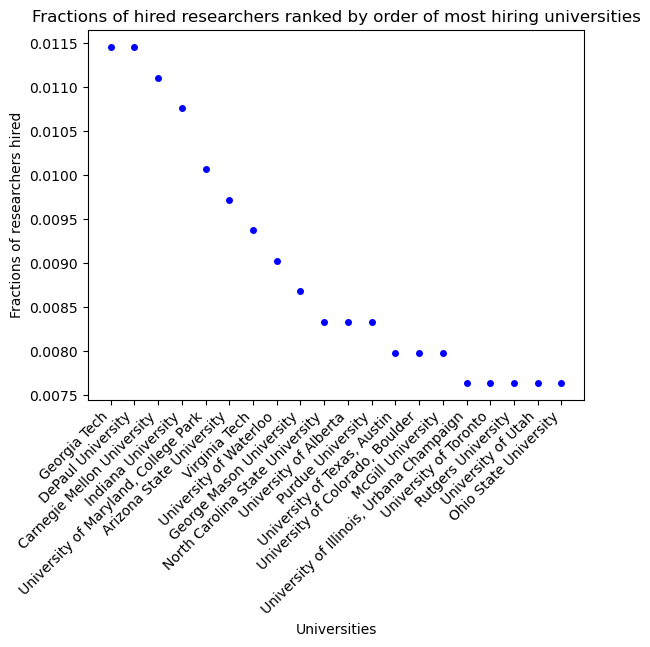

In [136]:
fig = plt.figure()
ax = plt.gca()
plot = ax.plot(universities_hiring, fractions_hiring, 'o', c='blue', markersize= 4)
plt.ylabel('Fractions of researchers hired')
plt.xlabel('Universities')
plt.title('Fractions of hired researchers ranked by order of most hiring universities')
ax.set_xticklabels(universities_hiring, rotation=45, ha="right")

Text(0.5, 1.0, 'Degree distribution for the University hiring network')

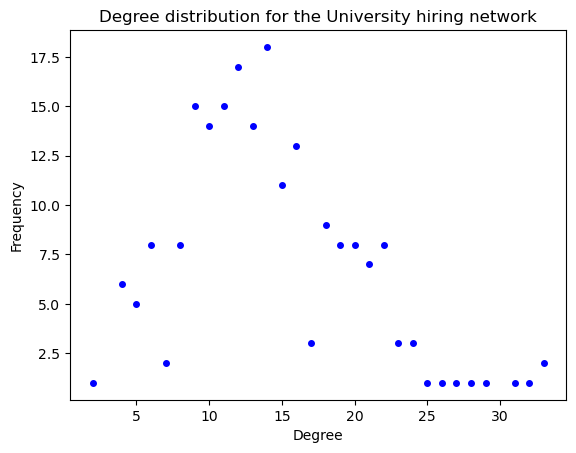

In [137]:
import collections
degree_seq = [d[1] for d in sorted_degree]
degreeCount = collections.Counter(degree_seq)
degreeCount = pd.DataFrame.from_dict(degreeCount, orient='index').reset_index()
fig = plt.figure()
ax = plt.gca()
ax.plot(degreeCount['index'], degreeCount[0], 'o', c='blue', markersize= 4)
plt.ylabel('Frequency')
plt.xlabel('Degree')
plt.title('Degree distribution for the University hiring network')

Here, one edge represents one researcher, and as the degree number is the number of edges / number of nodes, here it represents the number of researchers hired in average per university. As we can see, there is a lot of universities that are hiring a low number of researchers and some are leaders in hiring. 

In [138]:
# (b) fraction of all researchers (i.e. total number of edges) that are trained by the N universities whose students get hired the most.(i.e. highest out_degree = highest number of adjacent out_edges):
# sort universities by their score:
from operator import itemgetter
degrees = dict(UniG.out_degree(UniG.nodes()))
sorted_degree = sorted(degrees.items(), key=itemgetter(1), reverse=True)
universities_training = []
fractions_training = []
N = 20 # top 20 universities
# And the top N most hiring universities are:
for university, degree in sorted_degree[:N]:
    fraction_training = (degree/len(UniG.edges))
    fractions_training.append(fraction_training)
    print(UniG.nodes[university]['name'], 'hires', degree, 'researchers over', len(UniG.edges), 'i.e. {:.1%} of all researchers.'.format(fraction_training))
    universities_training.append(UniG.nodes[university]['name'])

University of Illinois, Urbana Champaign hires 94 researchers over 2881 i.e. 3.3% of all researchers.
MIT hires 87 researchers over 2881 i.e. 3.0% of all researchers.
Stanford University hires 73 researchers over 2881 i.e. 2.5% of all researchers.
UC Berkeley hires 72 researchers over 2881 i.e. 2.5% of all researchers.
Carnegie Mellon University hires 71 researchers over 2881 i.e. 2.5% of all researchers.
Purdue University hires 71 researchers over 2881 i.e. 2.5% of all researchers.
Cornell University hires 69 researchers over 2881 i.e. 2.4% of all researchers.
University of Texas, Austin hires 65 researchers over 2881 i.e. 2.3% of all researchers.
Princeton University hires 64 researchers over 2881 i.e. 2.2% of all researchers.
University of Wisconsin, Madison hires 62 researchers over 2881 i.e. 2.2% of all researchers.
University of Pennsylvania hires 58 researchers over 2881 i.e. 2.0% of all researchers.
University of Maryland, College Park hires 56 researchers over 2881 i.e. 1.9% o

C:\Users\camil\AppData\Local\Temp/ipykernel_3984/2286407536.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(universities_training, rotation=45, ha="right")


[Text(0, 0, 'University of Illinois, Urbana Champaign'),
 Text(1, 0, 'MIT'),
 Text(2, 0, 'Stanford University'),
 Text(3, 0, 'UC Berkeley'),
 Text(4, 0, 'Carnegie Mellon University'),
 Text(5, 0, 'Purdue University'),
 Text(6, 0, 'Cornell University'),
 Text(7, 0, 'University of Texas, Austin'),
 Text(8, 0, 'Princeton University'),
 Text(9, 0, 'University of Wisconsin, Madison'),
 Text(10, 0, 'University of Pennsylvania'),
 Text(11, 0, 'University of Maryland, College Park'),
 Text(12, 0, 'University of Washington'),
 Text(13, 0, 'University of Massachusetts, Amherst'),
 Text(14, 0, 'University of Minnesota, Minneapolis'),
 Text(15, 0, 'University of Toronto'),
 Text(16, 0, 'UCLA'),
 Text(17, 0, 'Georgia Tech'),
 Text(18, 0, 'Ohio State University'),
 Text(19, 0, 'Harvard University')]

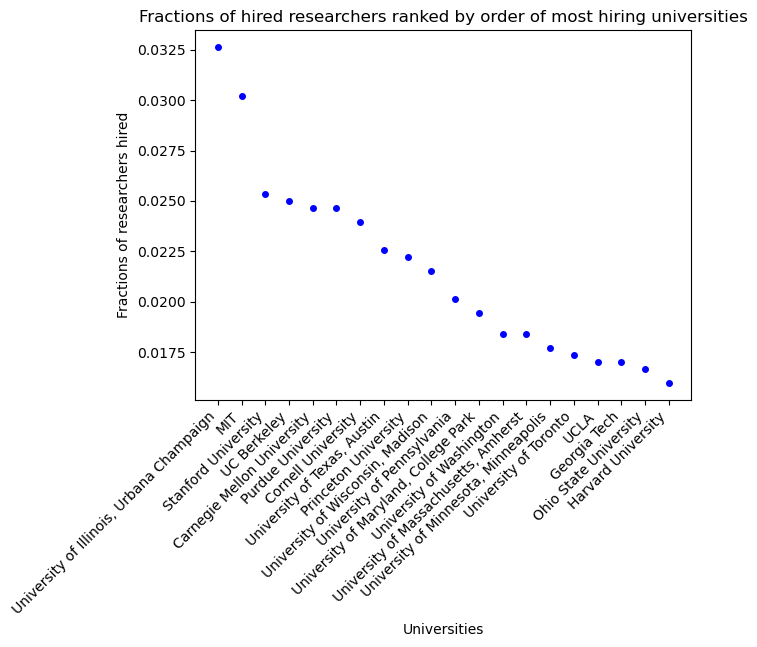

In [139]:
fig = plt.figure()
ax = plt.gca()
plot = ax.plot(universities_training, fractions_training, 'o', c='blue', markersize= 4)
plt.ylabel('Fractions of researchers hired')
plt.xlabel('Universities')
plt.title('Fractions of hired researchers ranked by order of most hiring universities')
ax.set_xticklabels(universities_training, rotation=45, ha="right")

3. **/Multiple choice:/** Which centrality metric(s) is/are illustrated in the plot you made for the previous subtask? Select all that apply from the list below and **justify your answer.**
    1. Betweenness centrality
    2. In-degree centrality
    3. Out-degree centrality
    4. PageRank centrality

In-degree centrality and Out-degree centrality because in-degrees are rearchers getting hired by the said university (target) and out-degrees are researchers trained by the said university, that are hired by others.

4. **/True or false:/** Search engines such as Google have historically used PageRank centrality as a signal to determine the importance of pages on the Web. Is the following statement **true** or **false**? Justify. **"In the faculty hiring network, PageRank centrality is positively correlated with university score, that is, universities with higher scores are more likely to also have higher PageRank centrality."**

True because university scores allow to rank them according to their scores.

**CORRECTION** False

Universities are prestigious not because they hire people, but because people who are trained there are hired elsewhere. Thus, a directed edge (u,v) in this graph cannot be understood as an "endorsement" which is what is captured by the pagerank centrality metric.

### Task 2 — (15 points)

Each hiring decision $(u,v)$ connects two different universities with different scores.

1. Divide the universities into quintiles according to their scores ($Q_1$ to $Q_5$, where $Q_5$ contains the highest-ranked universities, i.e., those with the highest scores). Create a succinct plot that captures, for each pair of quintiles ($Q_i$, $Q_j$), what fraction of people in the dataset who got their Ph.D. from a university in $Q_i$ were hired by a university in $Q_j$.


2. **/Multiple choice:/** What does the plot made in the previous subtask reveal about the faculty hiring process? Select one of the following options and justify your answer.
    1. Ph.D. graduates who are hired as professors usually go to universities that are better than the universities where they were trained.
    2. Ph.D. graduates who are hired as professors usually go to universities that are around the same or worse than the universities where they were trained.

3. **/True or false:/** Let $E$ be the set of edges from the hiring network, and let $X$ be defined as follows:
$$X = \frac{|(u,v) \in E : u \in Q_1 \text{ and } v \in Q_5 |}{{|(u,v) \in E : u \in Q_1|}}$$
 *Thinking critically about the data that was given to you,* is the following statement **true** or **false**? Justify your answer. **"If I get my Ph.D. in a 1st-quintile university, I have a chance of around X * 100%  of getting a job in a 5th-quintile university."**


---
**Hints:**
- [pandas.qcut](https://pandas.pydata.org/docs/reference/api/pandas.qcut.html) makes splitting data into quantiles easy!


In [151]:
# Divide universities into quintiles according to their score with pandas.qcut:
nodes['quintile'] = pd.qcut(nodes['score'], 5, labels=False)
nodes.sample(10)

,score,name,quintile
u,,,
44,75.851796,University of Pittsburgh,3
2,99.956665,UC Berkeley,4
90,47.267212,Wayne State University,2
77,56.058718,"Washington State University, Pullman",3
16,91.333081,New York University,4
179,12.003683,University of Tulsa,0
53,66.014842,University of Houston,3
175,12.485781,Northeastern University,0
140,26.428688,"Concordia University, Montreal",1


In [172]:
# Divide nodes with respect to their quintiles and compute for each pair of quintiles ($Q_i$, $Q_j$) what fraction of people in the dataset from a university in $Q_i$ were hired by a university in $Q_j$:
Q1 = nodes[nodes['quintile'] == 0]
Q2 = nodes[nodes['quintile'] == 1]
Q3 = nodes[nodes['quintile'] == 2]
Q4 = nodes[nodes['quintile'] == 3]
Q5 = nodes[nodes['quintile'] == 4]
# Compute the fraction of people in Q1 that were hired by Q2, Q3, Q4, Q5:
Q1_hired_by_Q1 = len(edges[(edges['u'].isin(Q1.index)) & (edges['v'].isin(Q1.index))])/len(Q1)
Q1_hired_by_Q2 = len(edges[(edges['u'].isin(Q1.index)) & (edges['v'].isin(Q2.index))])/len(Q1)
Q1_hired_by_Q3 = len(edges[(edges['u'].isin(Q1.index)) & (edges['v'].isin(Q3.index))])/len(Q1)
Q1_hired_by_Q4 = len(edges[(edges['u'].isin(Q1.index)) & (edges['v'].isin(Q4.index))])/len(Q1)
Q1_hired_by_Q5 = len(edges[(edges['u'].isin(Q1.index)) & (edges['v'].isin(Q5.index))])/len(Q1)
# Compute the fraction of people in Q2 that were hired by Q1, Q3, Q4, Q5:
Q2_hired_by_Q1 = len(edges[(edges['u'].isin(Q2.index)) & (edges['v'].isin(Q1.index))])/len(Q2)
Q2_hired_by_Q2 = len(edges[(edges['u'].isin(Q2.index)) & (edges['v'].isin(Q2.index))])/len(Q2)
Q2_hired_by_Q3 = len(edges[(edges['u'].isin(Q2.index)) & (edges['v'].isin(Q3.index))])/len(Q2)
Q2_hired_by_Q4 = len(edges[(edges['u'].isin(Q2.index)) & (edges['v'].isin(Q4.index))])/len(Q2)
Q2_hired_by_Q5 = len(edges[(edges['u'].isin(Q2.index)) & (edges['v'].isin(Q5.index))])/len(Q2)
# Compute the fraction of people in Q3 that were hired by Q1, Q2, Q4, Q5:
Q3_hired_by_Q1 = len(edges[(edges['u'].isin(Q3.index)) & (edges['v'].isin(Q1.index))])/len(Q3)
Q3_hired_by_Q2 = len(edges[(edges['u'].isin(Q3.index)) & (edges['v'].isin(Q2.index))])/len(Q3)
Q3_hired_by_Q3 = len(edges[(edges['u'].isin(Q3.index)) & (edges['v'].isin(Q3.index))])/len(Q3)
Q3_hired_by_Q4 = len(edges[(edges['u'].isin(Q3.index)) & (edges['v'].isin(Q4.index))])/len(Q3)
Q3_hired_by_Q5 = len(edges[(edges['u'].isin(Q3.index)) & (edges['v'].isin(Q5.index))])/len(Q3)
# Compute the fraction of people in Q4 that were hired by Q1, Q2, Q3, Q5:
Q4_hired_by_Q1 = len(edges[(edges['u'].isin(Q4.index)) & (edges['v'].isin(Q1.index))])/len(Q4)
Q4_hired_by_Q2 = len(edges[(edges['u'].isin(Q4.index)) & (edges['v'].isin(Q2.index))])/len(Q4)
Q4_hired_by_Q3 = len(edges[(edges['u'].isin(Q4.index)) & (edges['v'].isin(Q3.index))])/len(Q4)
Q4_hired_by_Q4 = len(edges[(edges['u'].isin(Q4.index)) & (edges['v'].isin(Q4.index))])/len(Q4)
Q4_hired_by_Q5 = len(edges[(edges['u'].isin(Q4.index)) & (edges['v'].isin(Q5.index))])/len(Q4)
# Compute the fraction of people in Q5 that were hired by Q1, Q2, Q3, Q4:
Q5_hired_by_Q1 = len(edges[(edges['u'].isin(Q5.index)) & (edges['v'].isin(Q1.index))])/len(Q5)
Q5_hired_by_Q2 = len(edges[(edges['u'].isin(Q5.index)) & (edges['v'].isin(Q2.index))])/len(Q5)
Q5_hired_by_Q3 = len(edges[(edges['u'].isin(Q5.index)) & (edges['v'].isin(Q3.index))])/len(Q5)
Q5_hired_by_Q4 = len(edges[(edges['u'].isin(Q5.index)) & (edges['v'].isin(Q4.index))])/len(Q5)
Q5_hired_by_Q5 = len(edges[(edges['u'].isin(Q5.index)) & (edges['v'].isin(Q5.index))])/len(Q5)

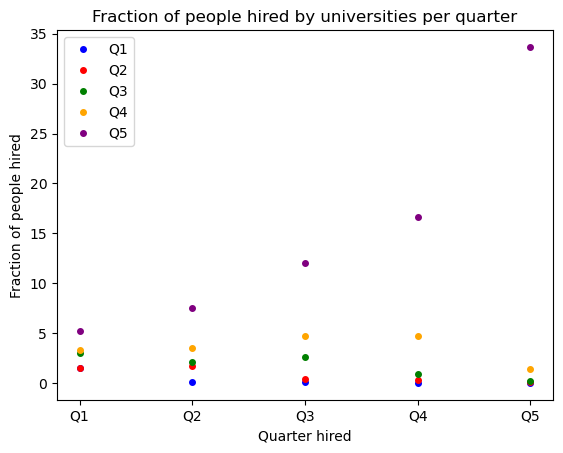

In [173]:
# Plot the fractions:
fig = plt.figure()
ax = plt.gca()
plot = ax.plot([Q1_hired_by_Q1, Q1_hired_by_Q2, Q1_hired_by_Q3, Q1_hired_by_Q4, Q1_hired_by_Q5], 'o', c='blue', markersize= 4)
plot = ax.plot([Q2_hired_by_Q1, Q2_hired_by_Q2, Q2_hired_by_Q3, Q2_hired_by_Q4, Q2_hired_by_Q5], 'o', c='red', markersize= 4)
plot = ax.plot([Q3_hired_by_Q1, Q3_hired_by_Q2, Q3_hired_by_Q3, Q3_hired_by_Q4, Q3_hired_by_Q5], 'o', c='green', markersize= 4)
plot = ax.plot([Q4_hired_by_Q1, Q4_hired_by_Q2, Q4_hired_by_Q3, Q4_hired_by_Q4, Q4_hired_by_Q5], 'o', c='orange', markersize= 4)
plot = ax.plot([Q5_hired_by_Q1, Q5_hired_by_Q2, Q5_hired_by_Q3, Q5_hired_by_Q4, Q5_hired_by_Q5], 'o', c='purple', markersize= 4)
ax.set_xticks([0,1,2,3, 4])
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
ax.set_xlabel('Quarter hired')
ax.set_ylabel('Fraction of people hired')
ax.set_title('Fraction of people hired by universities per quarter')
ax.legend(['Q1', 'Q2', 'Q3', 'Q4', 'Q5'], loc='upper left')
plt.show()

Q5 represents higher quintile, Q1 the lower in terms of scores. We can see that PhD graduates are usually hired by universities from the same quantile than the one in which they were trained/got their PhD. Indeed, researchers from universities in Q3 are mostly hired by Q3, Q2 and Q1 while much less in Q4 and Q5. However, Q5 largely dominates in terms of hired researchers in every quarter.

2. **/Multiple choice:/** What does the plot made in the previous subtask reveal about the faculty hiring process? Select one of the following options and justify your answer.
    1. Ph.D. graduates who are hired as professors usually go to universities that are better than the universities where they were trained.
    2. Ph.D. graduates who are hired as professors usually go to universities that are around the same or worse than the universities where they were trained.

2. cf above

3. **/True or false:/** Let $E$ be the set of edges from the hiring network, and let $X$ be defined as follows:
$$X = \frac{|(u,v) \in E : u \in Q_1 \text{ and } v \in Q_5 |}{{|(u,v) \in E : u \in Q_1|}}$$
 *Thinking critically about the data that was given to you,* is the following statement **true** or **false**? Justify your answer. **"If I get my Ph.D. in a 1st-quintile university, I have a chance of around X * 100%  of getting a job in a 5th-quintile university."**

In [180]:
print(len(Q1), len(Q2), len(Q3), len(Q4), len(Q5))
print(len(edges['v'].isin(Q5.index)), len(edges['v'].isin(Q1.index)))

41 41 41 41 41
4388 4388


**CORRECTION** False

One shortcoming of the data at hand is that we do not get any information about individuals trained at a given (american) university that never go on to get hired by another (american) university. It could be that all universities train the same amount of Ph.D. students but that those in the worse universities almost never get hired.

### Task 3 — (25 points)

Let the "source university" of a person be the university at which the person got their Ph.D., and let their "target university" be the university at which they were hired after their Ph.D.


1. For each hiring decision $(u, v)$, let the score gain ($d$) be defined as the difference between the scores of the target university and the source university (target university score minus source university score; see hint for example). Calculate the average difference for men ($\bar{d_{M}}$) and for women ($\bar{d_{F}}$) in the dataset. Determine whether the difference between these two averages ($\bar{d_{M}}$ and $\bar{d_{F}}$) is statistically significant.

2. **/True or false:/** Is the following statement **true** or **false**? Justify your answer. **"The results you obtained in Task 3.1 do not refute the hypothesis that women are disadvantaged in the faculty hiring process."**

3. For each quintile $Q$ from Task 2.1, calculate the following: **(a)** the percentage of women among hiring decisions $(u, v)$ with $u \in Q$ ; and **b)** the average score gain for hiring decisions $(u, v)$ with $u \in Q$.

4. **/Discuss:/** Considering the results obtained in Task 3.3, why is comparing the average score gain for men ($\bar{d_{M}}$) and women ($\bar{d_{F}}$) insufficient for determining the causal effect of gender on score gain?

5. Use `statsmodels` to run a linear regression where hiring decisions (edges of the hiring network) are the data points, gender and source-university score are the predictors, and score gain is the outcome. Report the summary of your model.

6. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"The results you obtained in Task 3.5 suggest that academic hiring decisions are unfair to women."**

---
**Hint** — The university with the best score is Stanford University (score 100), and the university with the 10th best score is the University of Washington (score 95.26). If someone was trained at Stanford and then got a job at the University of Washington, their score gain is $95.26 - 100 = -4.74$.

Let the "source university" of a person be the university at which the person got their Ph.D., and let their "target university" be the university at which they were hired after their Ph.D.


1. For each hiring decision $(u, v)$, let the score gain ($d$) be defined as the difference between the scores of the target university and the source university (target university score minus source university score; see hint for example). Calculate the average difference for men ($\bar{d_{M}}$) and for women ($\bar{d_{F}}$) in the dataset. Determine whether the difference between these two averages ($\bar{d_{M}}$ and $\bar{d_{F}}$) is statistically significant.

In [191]:
nodes

,score,name,quintile
u,,,
1,100.000000,Stanford University,4
2,99.956665,UC Berkeley,4
3,99.301230,MIT,4
4,98.369536,California Institute of Technology,4
5,97.892855,Harvard University,4
...,...,...,...
201,2.535074,Pace University,0
202,2.470072,New Mexico Institute of Mining and Technology,0
203,2.367152,"University of Nevada, Reno",0


In [194]:
target_scores = pd.merge(edges, nodes, left_on='v', right_index = True)
target_scores = target_scores[['v', 'score', 'gender']]
source_scores = pd.merge(edges, nodes, left_on='u', right_index = True)
source_scores = source_scores[['u', 'score', 'gender']]

,u,score,gender
0,1,100.000000,F
1,1,100.000000,F
2,1,100.000000,F
3,1,100.000000,M
4,1,100.000000,M
...,...,...,...
4383,194,4.409295,M
4384,198,3.298846,M
4385,200,2.795082,F
4386,204,0.016250,M


In [195]:
# For each graph edge, compute the score gain d = difference between target and source university scores:
edges['d'] = edges['v'].map(target_scores['score']) - edges['u'].map(source_scores['score'])
# Separate the edges into two dataframes for each gender:
edges_men = edges[edges['gender'] == 'M'] 
edges_women = edges[edges['gender'] == 'F']
# Compute the average score gain for each gender:
avg_edges_d_men = edges_men['d'].mean()
avg_edges_d_women = edges_women['d'].mean()

In [204]:
# Print averages:
print(avg_edges_d_men, avg_edges_d_women)

-13.361910669571218 -10.948502714438519


In [202]:
# Our sample sizes are different, so we need to compute the standard error of the mean:
print(len(edges_men['d']), len(edges_women['d']))

2379 2009


In [203]:
from scipy.stats import ttest_ind
# Determine whether "avg_edges_d_men" and "avg_edges_d_women" are significantly different:
ttest_ind(edges_men['d'], edges_women['d'], equal_var=False) # equal_var=False because our sample sizes are different

Ttest_indResult(statistic=-4.6015258407185, pvalue=4.313082042379169e-06)

From the independent two-sided t-test, we obtain a p-value of 4.31e-6 < 0.05, which means that * $p<=0.05$ -> We can reject the null hypothesis that the two means are the same (there is significant evidence for the alternative hypothesis H1 that the means are unequal).

2. **/True or false:/** Is the following statement **true** or **false**? Justify your answer. **"The results you obtained in Task 3.1 do not refute the hypothesis that women are disadvantaged in the faculty hiring process."**

There is significant evidence that the average score gain ($d$) i.e. the difference between the scores of the target university and the source university for men and women are unequal with the two-sided t-test but that does not mean how unequal. The two-sided t-test does not say if women average is lower than men average or the reverse. Furthermore, the p-value significative does not proves the alternative hypothesis in favour of one or the other average.

**CORRECTION** True

$\hat{d_M}$ is bigger than $\hat{d_F}$ and this difference is statistically significant. 
In case there is no other confounder, this would indicate that men in the data are, in average, decreasing their institutional score less than women as they go from PhD students to faculty.
In that context, it can't be said that the results refute the statement.

3. For each quintile $Q$ from Task 2.1, calculate the following: **(a)** the percentage of women among hiring decisions $(u, v)$ with $u \in Q$ ; and **b)** the average score gain for hiring decisions $(u, v)$ with $u \in Q$.

In [206]:
edges

,u,v,gender,d
0,1,1,F,0.000000
1,1,1,F,0.000000
2,1,1,F,0.000000
3,1,1,M,0.000000
4,1,1,M,0.000000
...,...,...,...,...
4383,194,194,M,0.043335
4384,198,198,M,0.000000
4385,200,200,F,0.000000
4386,204,204,M,-0.655436


In [218]:
# Compute the percentage of women among edges with their source university belonging to Q1, Q2, Q3, Q4, Q5:
Q1_women = 100*len(edges[(edges['u'].isin(Q1.index)) & (edges['gender'] == 'F')])/len(edges)
Q2_women = 100*len(edges[(edges['u'].isin(Q2.index)) & (edges['gender'] == 'F')])/len(edges)
Q3_women = 100*len(edges[(edges['u'].isin(Q3.index)) & (edges['gender'] == 'F')])/len(edges)
Q4_women = 100*len(edges[(edges['u'].isin(Q4.index)) & (edges['gender'] == 'F')])/len(edges)
Q5_women = 100*len(edges[(edges['u'].isin(Q5.index)) & (edges['gender'] == 'F')])/len(edges)
print(Q1_women, Q2_women, Q3_women, Q4_women, Q5_women)

0.18231540565177756 0.7292616226071102 2.4612579762989975 6.608933454876937 35.80218778486782


In [210]:
# Compute the average score gain for edges within each quarter:
Q1_d = edges[edges['u'].isin(Q1.index)]['d'].mean()
Q2_d = edges[edges['u'].isin(Q2.index)]['d'].mean()
Q3_d = edges[edges['u'].isin(Q3.index)]['d'].mean()
Q4_d = edges[edges['u'].isin(Q4.index)]['d'].mean()
Q5_d = edges[edges['u'].isin(Q5.index)]['d'].mean()
print(Q1_d, Q2_d, Q3_d, Q4_d, Q5_d)

-31.061853459310374 -23.05393803152592 -23.41499734185461 -16.49039197300213 -8.944027138203401


4. **/Discuss:/** Considering the results obtained in Task 3.3, why is comparing the average score gain for men ($\bar{d_{M}}$) and women ($\bar{d_{F}}$) insufficient for determining the causal effect of gender on score gain?

Because as we can see, the percentage of women in each quintile is very different from one another, meaning that the women percentage is very unbalanced amongst universities. Hence, we cannot compare the average score gain knowing that the gender is heterogeneous in the dataset.

**CORRECTION** It is not appropriate because the score of the source university is a confounder. Better ranked universities have more women *and* have, in average, lower score gain.

5. Use `statsmodels` to run a linear regression where hiring decisions (edges of the hiring network) are the data points, gender and source-university score are the predictors, and score gain is the outcome. Report the summary of your model.

In [224]:
lin_reg_data = pd.merge(edges, nodes, left_on='u', right_index = True)
lin_reg_data = lin_reg_data[['u', 'gender', 'd']]
# Rename the "d" column to "score_gain":
lin_reg_data = lin_reg_data.rename(columns={'d': 'score_gain'})
# Rename the "u" column to "source_university":
lin_reg_data = lin_reg_data.rename(columns={'u': 'source_university'})
lin_reg_data

,source_university,gender,score_gain
0,1,F,0.000000
1,1,F,0.000000
2,1,F,0.000000
3,1,M,0.000000
4,1,M,0.000000
...,...,...,...
4383,194,M,0.043335
4384,198,M,0.000000
4385,200,F,0.000000
4386,204,M,-0.655436


In [226]:
# Linear regression model with edges being the data points, gender and source university are the predictors, and score gain is the response variable:
# Declares the model
mod = smf.ols(formula='score_gain ~ source_university + C(gender)', data=lin_reg_data)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             score_gain   R-squared:                       0.114
Model:                            OLS   Adj. R-squared:                  0.113
Method:                 Least Squares   F-statistic:                     281.3
Date:                Fri, 13 Jan 2023   Prob (F-statistic):          1.17e-115
Time:                        15:20:19   Log-Likelihood:                -18518.
No. Observations:                4388   AIC:                         3.704e+04
Df Residuals:                    4385   BIC:                         3.706e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -6.6655      0.41



6. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"The results you obtained in Task 3.5 suggest that academic hiring decisions are unfair to women."**

The gender coefficient has a p-value of 0.639 > 0.05 which not statistically significant so we cannot conclude anything on the influence of the gender predictor on the score gain of hiring decisions. 

**CORRECTION** False, because after we controlled for the score of the university where people did their Ph.D. at, we find that gender is not significant!

## Part 2 — Tennis interviews

For the second part of the exam, you will work with text data extracted from questions asked during post-match tennis interviews and from
TV commentary done during the tennis match.


Examples of interview questions:

> That last set seemed like a faultless performance. Is that the way you saw it?

> How disappointing is that loss for you?

> As a spectator, would you rather watch a guy with big aces or a match with lots of rallies?

Example of commentary text:

>  Serena is desperate to shake herself into action. She lets out an almighty shriek when she goes 30-15 up, but Azarenka responds with a brilliant forehand. The level of Williams' scream goes up and up during the next point, and she lets out another roar when she belts a forehand cross court win the point. She wraps the game up next time round, and she looked something like back to her best there!


## Files (in the `data` folder)

- `questions.tsv.gz` a tab-separated compressed file containing interview questions
and some metadata. We refer to this dataset as the "questions dataset."
Each row contains a question made to a specific player after a match.
The file has the following columns:
    - `questions` — the text of the question asked; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the player;
    - `ranking` — the ranking of the player at the time;
    - `similarity` — this column will be explained later in the exam.

- `commentary.tsv.gz` a tab-separated compressed file containing TV commentary done during
the tennis match. We refer to this dataset as the "commentary dataset." Each line contains
a piece of commentary done in a tennis match.
The file has the following columns:
    - `commentary` — the text of the commentary; **Note that you will never be asked to use this row; it is merely meant to help you understand the data better**.
    - `gender` — the gender of the players in the match;

- `TFIDF.npz`, a file containing 2D numpy arrays saved in the `.npz` format that
will be used in Task 4.

Both datasets are **balanced regarding gender,** i.e., they have the same number of rows about men as about women.


Commentary text, as well as interview questions, have been preprocessed to make your life easier, as follows:

- We replaced all words starting with upper-case letters with the special string `'--ENT--'`. This was done to remove personal names (e.g., Alice, Bob), which could help predict whether the text is associated with a male or a female tennis player.
- We removed the first word in each sentence. This was done because, for the first word of each sentence, it is difficult to know whether it is a personal name or simply a regular word.
- We replaced all gendered pronouns in the text (he/him/his and she/her/hers) with the special string `'--PRON--'`. This, too, was done because these words would make it easy to predict whether the text is associated with a male or a female tennis player.
- We removed punctuation and stop words (to reduce the dimensionality of the data).

The above example commentary text thus appears as follows in the data provided to you:

> desperate shake action lets almighty shriek --PRON-- goes 30 15 --ENT-- responds brilliant forehand level --ENT-- scream goes point --PRON-- lets roar --PRON-- belts forehand cross court win point wraps game time round --PRON-- looked like --PRON-- best

We also provide some code for loading and displaying the dataset:

In [227]:
#  Part 2 ! PROVIDED CODE !
questions = pd.read_csv("./data/part-2/questions.tsv.gz", sep="\t", compression="infer")
commentary = pd.read_csv("./data/part-2/commentary.tsv.gz", sep="\t", compression="infer")

In [228]:
questions.head()

,questions,ranking,similarity,gender
0,successful --ENT-- today year,366,0.431568,F
1,players player admire growing,352,0.247449,F
2,shot clock thing countdown,441,0.702559,F
3,birthplace --ENT-- place lot --ENT-- --ENT-- b...,760,0.270464,F
4,--ENT-- match today,99,0.322474,F


In [262]:
questions.gender.value_counts()

0    1537
1    1463
Name: gender, dtype: int64

In [229]:
commentary.head()

,commentary,gender
0,restarts contest foot --ENT-- reaches 30 15 he...,M
1,start --ENT-- --ENT-- moves 15 0 ahead --ENT--...,M
2,continues struggle --ENT-- serve proves diffic...,M
3,hold 15 begin second set NoDjo gasp break --PR...,M
4,hold --ENT-- --PRON-- wo fight easily competit...,M


In [264]:
commentary.gender.value_counts()

0    1500
1    1500
Name: gender, dtype: int64

### Task 4  (20 points)

Your goal now is to investigate whether there is gender bias in the questions being asked to female vs. male players, i.e., whether men vs. women are asked different questions on average. You start your analysis with a classification framing.


To make your life easier, we already provided a TF-IDF matrix for each dataset (`commentary.tsv.gz` and `questions.tsv.gz`) and with code to load these matrices (which are numpy arrays).

- Each row in each matrix $M$ corresponds to a row in the corresponding dataframe, i.e., each row corresponds to a different question or a different piece of TV commentary.
- Each column in each matrix corresponds to a different word from the vocabulary.
- Each position $(i,j)$ in the matrix contains the TF-IDF score for word $j$ from the vocabulary in question or commentary $i$. That is, each term $M[i,j]$ corresponds to the term frequency (TF) of word $j$ in text $i$, multiplied by the inverse document frequency (IDF) of word $j$:


$$M[i,j] = \text{TF}(i,j) * \text{IDF}(j)$$


1. **/Multiple Choice:/** Which of the following is the correct way to calculate the term frequency and the inverse document frequency? Justify your answer, explaining what each of the two components should capture.
    - Option A:

    $$\text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option B:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents the $j$-th word occurs in}}{\text{number of documents}}$$

    - Option C:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in all documents} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$

    - Option D:

    $$ \text{TF}(i,j) = \text{number of times the $j$-th word occurs in the $i$-th document} $$

    $$\text{IDF}(j) =  \log \frac{\text{number of documents}}{\text{number of documents the $j$-th word occurs in}}$$



2. Leveraging the matrices described above, train two logistic regression classifiers (one for interview questions, the other for TV commentary) that use the TF-IDF vectors as features to predict the gender of the athletes. You should split each dataset into training and test sets using sklearn (see [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) using parameters `test_size=0.4` and `random_state=42`. You should use sklearn's logistic regression model (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)) using parameters `C=10` (which controls regularization) and `max_iter=2000`. For each dataset, train the model on the training set (with 60% of the data) and report the accuracy on the test set (with 40% of the data).

3. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"Based on the outcome of Task 4.2, the text from tennis commentary text is more gender-biased than post-match questions."**

4. The parameter `C` above controls a regularization penalty. The lower `C`, the stronger the regularization penalty (caveat: sklearn’s convention is the reverse of the convention you saw in class, where a *higher* $\lambda$ parameter meant a stronger regularization penalty ). For the questions dataset, re-run the classification task using the same setup as in Task 4.2, but now with `C=2000`. Report the accuracy.

5. **/Discuss:/** Explain why increasing `C` changed the results.


1. The correct way to calculate the term frequency and the inverse document frequency is option D. The inverse document frequency IDF(w) represents the information content (in terms of #bits) of event “randomly drawing a document that contains w” and the term frequency TF(w, d) represents the term frequency of word w in doc d. This is what the bag-of-words captures. In the TF-IDF matrix, the entry in row d and column w has the value tf(w, d) * idf(w).

2. Leveraging the matrices described above, train two logistic regression classifiers (one for interview questions, the other for TV commentary) that use the TF-IDF vectors as features to predict the gender of the athletes. You should split each dataset into training and test sets using sklearn (see [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)) using parameters `test_size=0.4` and `random_state=42`. You should use sklearn's logistic regression model (see [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression)) using parameters `C=10` (which controls regularization) and `max_iter=2000`. For each dataset, train the model on the training set (with 60% of the data) and report the accuracy on the test set (with 40% of the data).

In [230]:
# 4.2 ! PROVIDED CODE !
tmp = np.load("./data/part-2/TFIDF.npz")
TFIDF_commentary = tmp['commentary']
TFIDF_questions = tmp['questions']

TFIDF_questions

array([[0.60373585, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.19567434],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.13978562, ..., 0.        , 0.        ,
        0.        ],
       [0.59027928, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [234]:
TFIDF_commentary

array([[0.65551257, 0.0600858 , 0.05950864, ..., 0.        , 0.        ,
        0.        ],
       [0.78196059, 0.03583816, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.79636893, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.61461831, 0.16901202, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.77409435, 0.05321646, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.26163329, ..., 0.        , 0.        ,
        0.        ]])

In [235]:
X_questions = TFIDF_questions
X_commentary = TFIDF_commentary
print(len(X_questions), len(X_commentary))

3000 3000


In [265]:
# Transform genders in y_questions and y_commentary into 0s and 1s:
is_woman_questions = (questions["gender"]).astype("int").values # For each gender, if it is "F" then 1, else 0
is_woman_commentary = (commentary["gender"]).astype("int").values
print(len(is_woman_questions), len(is_woman_commentary))

3000 3000


In [267]:
is_woman_questions

array([1, 1, 1, ..., 0, 0, 0])

In [266]:
(is_woman_questions == 0).all()

False

In [268]:
# Split the data into training and test sets:
test_size = 0.4
random_state = 42
X_train_questions, X_test_questions, y_train_questions, y_test_questions = train_test_split(X_questions, is_woman_questions, test_size=test_size, random_state=random_state)
X_train_commentary, X_test_commentary, y_train_commentary, y_test_commentary = train_test_split(X_commentary, is_woman_commentary, test_size=test_size, random_state=random_state)

In [270]:
# Train logistic regression classifiers using TF-IDF vectors as features to predict the gender of athletes: 
from sklearn.linear_model import LogisticRegression 
# Set the regularization parameter C to 10 and the maximum number of iterations to 2000:
max_iter = 2000
# Train the model for questions dataset:
clf_questions = LogisticRegression(C = 10, random_state=random_state, max_iter=max_iter)
clf_questions.fit(X_train_questions, y_train_questions)
y_pred_questions = clf_questions.predict(X_test_questions)
accuracy_questions = accuracy_score(y_test_questions, y_pred_questions)

# Train the model for commentary dataset:
clf_commentary = LogisticRegression(C = 10, random_state=random_state, max_iter=max_iter)
clf_commentary.fit(X_train_commentary, y_train_commentary)
y_pred_commentary = clf_questions.predict(X_test_commentary)
accuracy_commentary = accuracy_score(y_test_commentary, y_pred_commentary)

# Print the accuracy scores for each regression model:
print("Accuracy scores for each regression model: Questions", accuracy_questions, "Commentaries:", accuracy_commentary)

Accuracy scores for each regression model: Questions 0.7108333333333333 Commentaries: 0.5158333333333334


3. **/True or false:/** Considering the following statement, answer **true** or **false** and justify your answer. **"Based on the outcome of Task 4.2, the text from tennis commentary text is more gender-biased than post-match questions."**

We cannot answer this question doing a comparison. Here, we simply have the accuracy of each model to predict the gender based on the text of questions and commentaries. The only thing we can say is that the model performs better for the questions text than for the commentaries text in predicting the athlete gender, because the accuracy of the commentaries text is nearly equal to chance.

**CORRECTION**: False. On the contrary, the above results suggest that questions are more gender biased than commentary. It is easier to discern men from women from questions than it is from commentary.

4. The parameter `C` above controls a regularization penalty. The lower `C`, the stronger the regularization penalty (caveat: sklearn’s convention is the reverse of the convention you saw in class, where a *higher* $\lambda$ parameter meant a stronger regularization penalty ). For the questions dataset, re-run the classification task using the same setup as in Task 4.2, but now with `C=2000`. Report the accuracy.

In [271]:
# Train logistic regression classifiers using TF-IDF vectors as features to predict the gender of athletes: 
max_iter = 2000
# Re-Train the model for questions dataset with C=2000:
clf_questions = LogisticRegression(C = 2000, random_state=random_state, max_iter=max_iter)
clf_questions.fit(X_train_questions, y_train_questions)
y_pred_questions = clf_questions.predict(X_test_questions)
accuracy_questions = accuracy_score(y_test_questions, y_pred_questions)

# Print the accuracy scores for each regression model:
print("Accuracy scores for each regression model: Questions", accuracy_questions)

Accuracy scores for each regression model: Questions 0.6891666666666667


5. **/Discuss:/** Explain why increasing `C` changed the results.

C controls the regularization penalty. According to the above, a higher C (2000 compared to 10 previously) corresponds to a lower regularization penalty. Hence, the lower the regularization the lower the penalization on weight vector norm, and the higher the overfitting because the model will try to capture and fit the most of the data noise, which generalizes less well to the test data and hence decreases the accuracy.

**CORRECTION**: We are performing classification tasks in sparse matrices where the number of features outnumber the number of datapoints. Thus, the lack of regularization can lead to overfitting. When we increase C we decrease the regularization penalty and thus increase overfitting.

### Task 5 — (20 pts)

You will now further inspect whether there is gender bias in the interview questions using an observational study framing. For this task, you will use the column `similarity` provided in the questions dataframe. This column captures how similar each question is to tennis-related text, i.e., a higher score indicates that the question is more about the topic of tennis. In contrast, a lower score means that the question may be personal or about other subjects.

1. Using `statsmodels`, run a linear regression with `similarity` as the outcome and `gender` as the predictor. Report the summary of your model.

2. **/True or false:/** According to the previous analysis, determine if the following statement is **true** or **false** and justify your answer. **"Men are asked questions unrelated to tennis more often than women."**

3. The ranking of players is a potential confounder here. We do not know whether the male and female players in the dataset have similar rankings. In that context, compute the average ranking for men and women. Determine if the difference is statistically significant. Additionally, create a scatter plot showing the relationship between ranking (on the y-axis) and similarity (in the x-axis) and compute Spearman's rank-correlation coefficient between `ranking` and `similarity`.

4. **/True or false:/** Assume that no variable other than `gender` and `ranking` can have any influence on the `similarity` of each question. Based on the analysis of the previous question, is the following statement **true** or **false**? Justify your answer. **"Ranking is not a worrisome confounder for the regression of Task 5.1."**

In [275]:
# Linear regression model with similarity as outcome and gender as predictor:
# Declares the model
mod = smf.ols(formula='similarity ~  gender', data=questions)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:             similarity   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     841.1
Date:                Fri, 13 Jan 2023   Prob (F-statistic):          3.16e-163
Time:                        17:20:06   Log-Likelihood:                 77.527
No. Observations:                3000   AIC:                            -151.1
Df Residuals:                    2998   BIC:                            -139.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6248      0.006    103.854      

# 1 = F, 0 = M

2. **/True or false:/** According to the previous analysis, determine if the following statement is **true** or **false** and justify your answer. **"Men are asked questions unrelated to tennis more often than women."**

The gender predictor has a p-value of 0 > 0.05, which is statistically non-significant, meaning that the predictor is not significantly linearly correlated with the similarity of questions with tennis. Hence, we cannot draw any conclusion regarding the gender-related similarity of questions.

**CORRECTION** False. The results of the above regression suggest that women are asked unrelated question the most. 
Note that being a men increases your similarity score by roughly 0.25, which means their questions 
are more closely related to the tennis-related text.

3. The ranking of players is a potential confounder here. We do not know whether the male and female players in the dataset have similar rankings. In that context, compute the average ranking for men and women. Determine if the difference is statistically significant. Additionally, create a scatter plot showing the relationship between ranking (on the y-axis) and similarity (in the x-axis) and compute Spearman's rank-correlation coefficient between `ranking` and `similarity`.

In [287]:
# Compute the average ranking for men and women:
avg_ranking_F = questions.loc[questions['gender'] == 1]['ranking'].mean()
avg_ranking_M = questions.loc[questions['gender'] == 0]['ranking'].mean()
print(avg_ranking_F, avg_ranking_M)
# Compute the standard error mean: 
std_err_F = questions.loc[questions['gender'] == 1]['ranking'].std()/np.sqrt(len(questions.loc[questions['gender'] == 1]['ranking']))
std_err_M = questions.loc[questions['gender'] == 0]['ranking'].std()/np.sqrt(len(questions.loc[questions['gender'] == 0]['ranking']))
print(std_err_F, std_err_M)

503.6179084073821 495.20234222511385
7.564823142999677 7.386279439576174


In [282]:
# Let's check the sample size for each gender, but we already know that the data is balanced:
print(len(questions.loc[questions['gender'] == 1]), len(questions.loc[questions['gender'] == 0]))

1463 1537


In [283]:
# t-test for the difference in average ranking between gender:
ttest_ind(questions.loc[questions['gender'] == 1]['ranking'], questions.loc[questions['gender'] == 0]['ranking'], equal_var=False)

Ttest_indResult(statistic=0.7959653302828104, pvalue=0.42611535466306416)

The p-value is not significant (>0.05) hence we cannot reject the null hypothesis that the means are the same (but cannot conclude H0 is true).

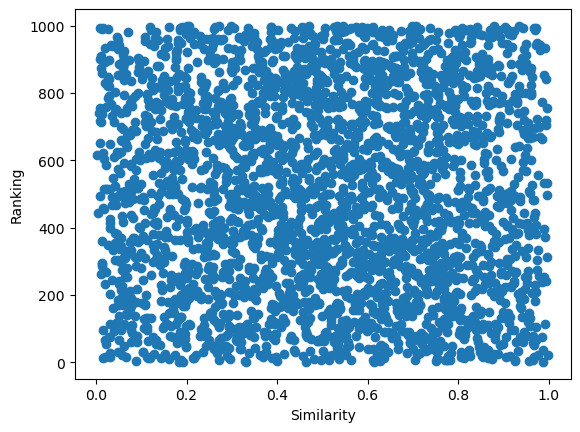

-0.00793480965681015


SignificanceResult(statistic=-0.00793480965681015, pvalue=0.663973935968952)

In [286]:
# Scatter plot showing the relationship between ranking (on the y-axis) and similarity (in the x-axis) 
plt.scatter(questions['similarity'], questions['ranking'])
plt.xlabel('Similarity')
plt.ylabel('Ranking')
plt.show()
# Compute Spearman's rank-correlation coefficient between `ranking` and `similarity`:
print(questions['ranking'].corr(questions['similarity'], method='spearman'))
stats.spearmanr(questions.similarity, questions.ranking)

4. **/True or false:/** Assume that no variable other than `gender` and `ranking` can have any influence on the `similarity` of each question. Based on the analysis of the previous question, is the following statement **true** or **false**? Justify your answer. **"Ranking is not a worrisome confounder for the regression of Task 5.1."**

True — under the assumptions that no variable other than `gender` and `ranking` can have any influence on `similarity`, we can rule out ranking as a confounder because it is completely uncorrelated with the similarity (Spearman correlation coeff of -0.07).